In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras

In [59]:
data2 = pd.read_csv('oasis_longitudinal.csv')
data2.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [60]:
data2.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [61]:
data2['SES'] = data2['SES'].fillna(np.round(data2['SES'].median()))
data2['MMSE'] = data2['MMSE'].fillna(data2['MMSE'].median())

In [62]:
data2.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.436997,27.351206,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.109307,3.675329,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [63]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
import shapely as shap
import seaborn as sns

sc = StandardScaler()

In [64]:
feats = ['M/F']
data22 = pd.get_dummies(data2, columns=feats, drop_first=True)
data22 = data22.set_index('Subject ID')
data22.head()

,MRI ID,Group,Visit,MR Delay,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,M/F_M
Subject ID,,,,,,,,,,,,,,
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,1
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,1
OAS2_0002,OAS2_0002_MR1,Demented,1,0,R,75,12,2.0,23.0,0.5,1678,0.736,1.046,1
OAS2_0002,OAS2_0002_MR2,Demented,2,560,R,76,12,2.0,28.0,0.5,1738,0.713,1.010,1
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,R,80,12,2.0,22.0,0.5,1698,0.701,1.034,1


In [65]:
feats=data22.drop(['Group', 'MRI ID','Hand', 'CDR', 'Visit'], axis=1)
feats['int_ses'] = data22['MMSE']/data22['SES']
feats['volume'] = data22['eTIV']*data22['nWBV']
feats['educ_age'] = data22['Age']-data22['EDUC']
X=feats
X.head()

,MR Delay,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,M/F_M,int_ses,volume,educ_age
Subject ID,,,,,,,,,,,,
OAS2_0001,0,87,14,2.0,27.0,1987,0.696,0.883,1,13.5,1382.952,73
OAS2_0001,457,88,14,2.0,30.0,2004,0.681,0.876,1,15.0,1364.724,74
OAS2_0002,0,75,12,2.0,23.0,1678,0.736,1.046,1,11.5,1235.008,63
OAS2_0002,560,76,12,2.0,28.0,1738,0.713,1.010,1,14.0,1239.194,64
OAS2_0002,1895,80,12,2.0,22.0,1698,0.701,1.034,1,11.0,1190.298,68


In [66]:
# feats=data22.drop(['Group', 'MRI ID','Hand', 'CDR','EDUC', 'Visit', 'ASF', 'MR Delay', 'M/F_M'], axis=1)
# feats['int_ses'] = data22['MMSE']/data22['SES']
# X=feats
# X.head()

In [67]:
#X_sc = sc.fit_transform(X)

In [68]:
y = pd.DataFrame([1 if i=='Demented' else 0 for i in data22['Group']])
y.head()

,0
0,0
1,0
2,1
3,1
4,1


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(279, 12)
(94, 12)
(279, 1)
(94, 1)


# Feature Selection

## Permutation Importance

In [71]:
X.columns

Index(['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF',
       'M/F_M', 'int_ses', 'volume', 'educ_age'],
      dtype='object')

In [72]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=200).fit(X_train, y_train)
np.round(rf.feature_importances_,4)

array([0.0681, 0.0632, 0.0558, 0.025 , 0.2953, 0.0663, 0.098 , 0.0604,
       0.0347, 0.1095, 0.0734, 0.0501])

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1681 ± 0.0717,MMSE
0.0340 ± 0.0366,nWBV
0.0319 ± 0.0000,M/F_M
0.0319 ± 0.0233,EDUC
0.0213 ± 0.0135,ASF
0.0191 ± 0.0248,volume
0.0170 ± 0.0104,SES
0.0149 ± 0.0104,educ_age
0.0106 ± 0.0190,eTIV
0.0085 ± 0.0159,MR Delay


## Alt. Feature Importances

In [74]:

shap.initjs()
xgbee.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgbee, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

AttributeError: module 'shapely' has no attribute 'initjs'

In [75]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
xgbee = XGBClassifier()
model = RandomForestClassifier()
rfe = RFE(xgbee, 8)
rfe = rfe.fit(X, y)

print(rfe.support_)
print(rfe.ranking_)
print(X.head(0))

[ True  True  True False  True False  True False  True False  True  True]
[1 1 1 3 1 2 1 4 1 5 1 1]
Empty DataFrame
Columns: [MR Delay, Age, EDUC, SES, MMSE, eTIV, nWBV, ASF, M/F_M, int_ses, volume, educ_age]
Index: []


## Correlations

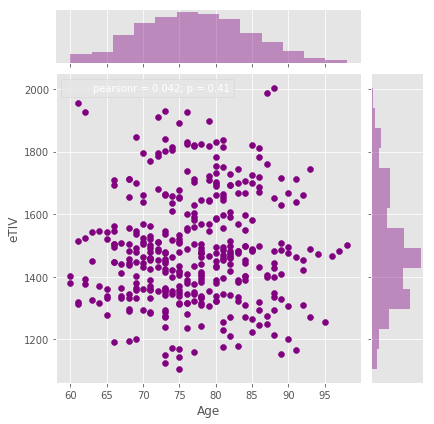

In [76]:
import seaborn as sns
import scipy.stats as stats

f = sns.jointplot(x="Age", y="eTIV", data=data22, color='purple')
f.annotate(stats.pearsonr)
plt.show();

In [77]:
X.corr().style.background_gradient('RdBu_r').set_precision(3)

,MR Delay,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,M/F_M,int_ses,volume,educ_age
MR Delay,1,0.205,0.0516,-0.0262,0.0666,0.12,-0.106,-0.124,0.048,0.0619,0.0728,0.172
Age,0.205,1,-0.0279,-0.0454,0.0553,0.0423,-0.518,-0.0351,-0.0377,0.0736,-0.172,0.937
EDUC,0.0516,-0.0279,1,-0.691,0.192,0.257,-0.0122,-0.242,0.0893,0.639,0.251,-0.375
SES,-0.0262,-0.0454,-0.691,1,-0.14,-0.249,0.0924,0.241,-0.0485,-0.877,-0.203,0.199
MMSE,0.0666,0.0553,0.192,-0.14,1,-0.0362,0.342,0.045,-0.169,0.331,0.109,-0.0158
eTIV,0.12,0.0423,0.257,-0.249,-0.0362,1,-0.21,-0.989,0.573,0.24,0.909,-0.0505
nWBV,-0.106,-0.518,-0.0122,0.0924,0.342,-0.21,1,0.213,-0.25,-0.0904,0.214,-0.476
ASF,-0.124,-0.0351,-0.242,0.241,0.045,-0.989,0.213,1,-0.562,-0.231,-0.898,0.0519
M/F_M,0.048,-0.0377,0.0893,-0.0485,-0.169,0.573,-0.25,-0.562,1,0.0535,0.464,-0.0662
int_ses,0.0619,0.0736,0.639,-0.877,0.331,0.24,-0.0904,-0.231,0.0535,1,0.196,-0.155


## All Plot

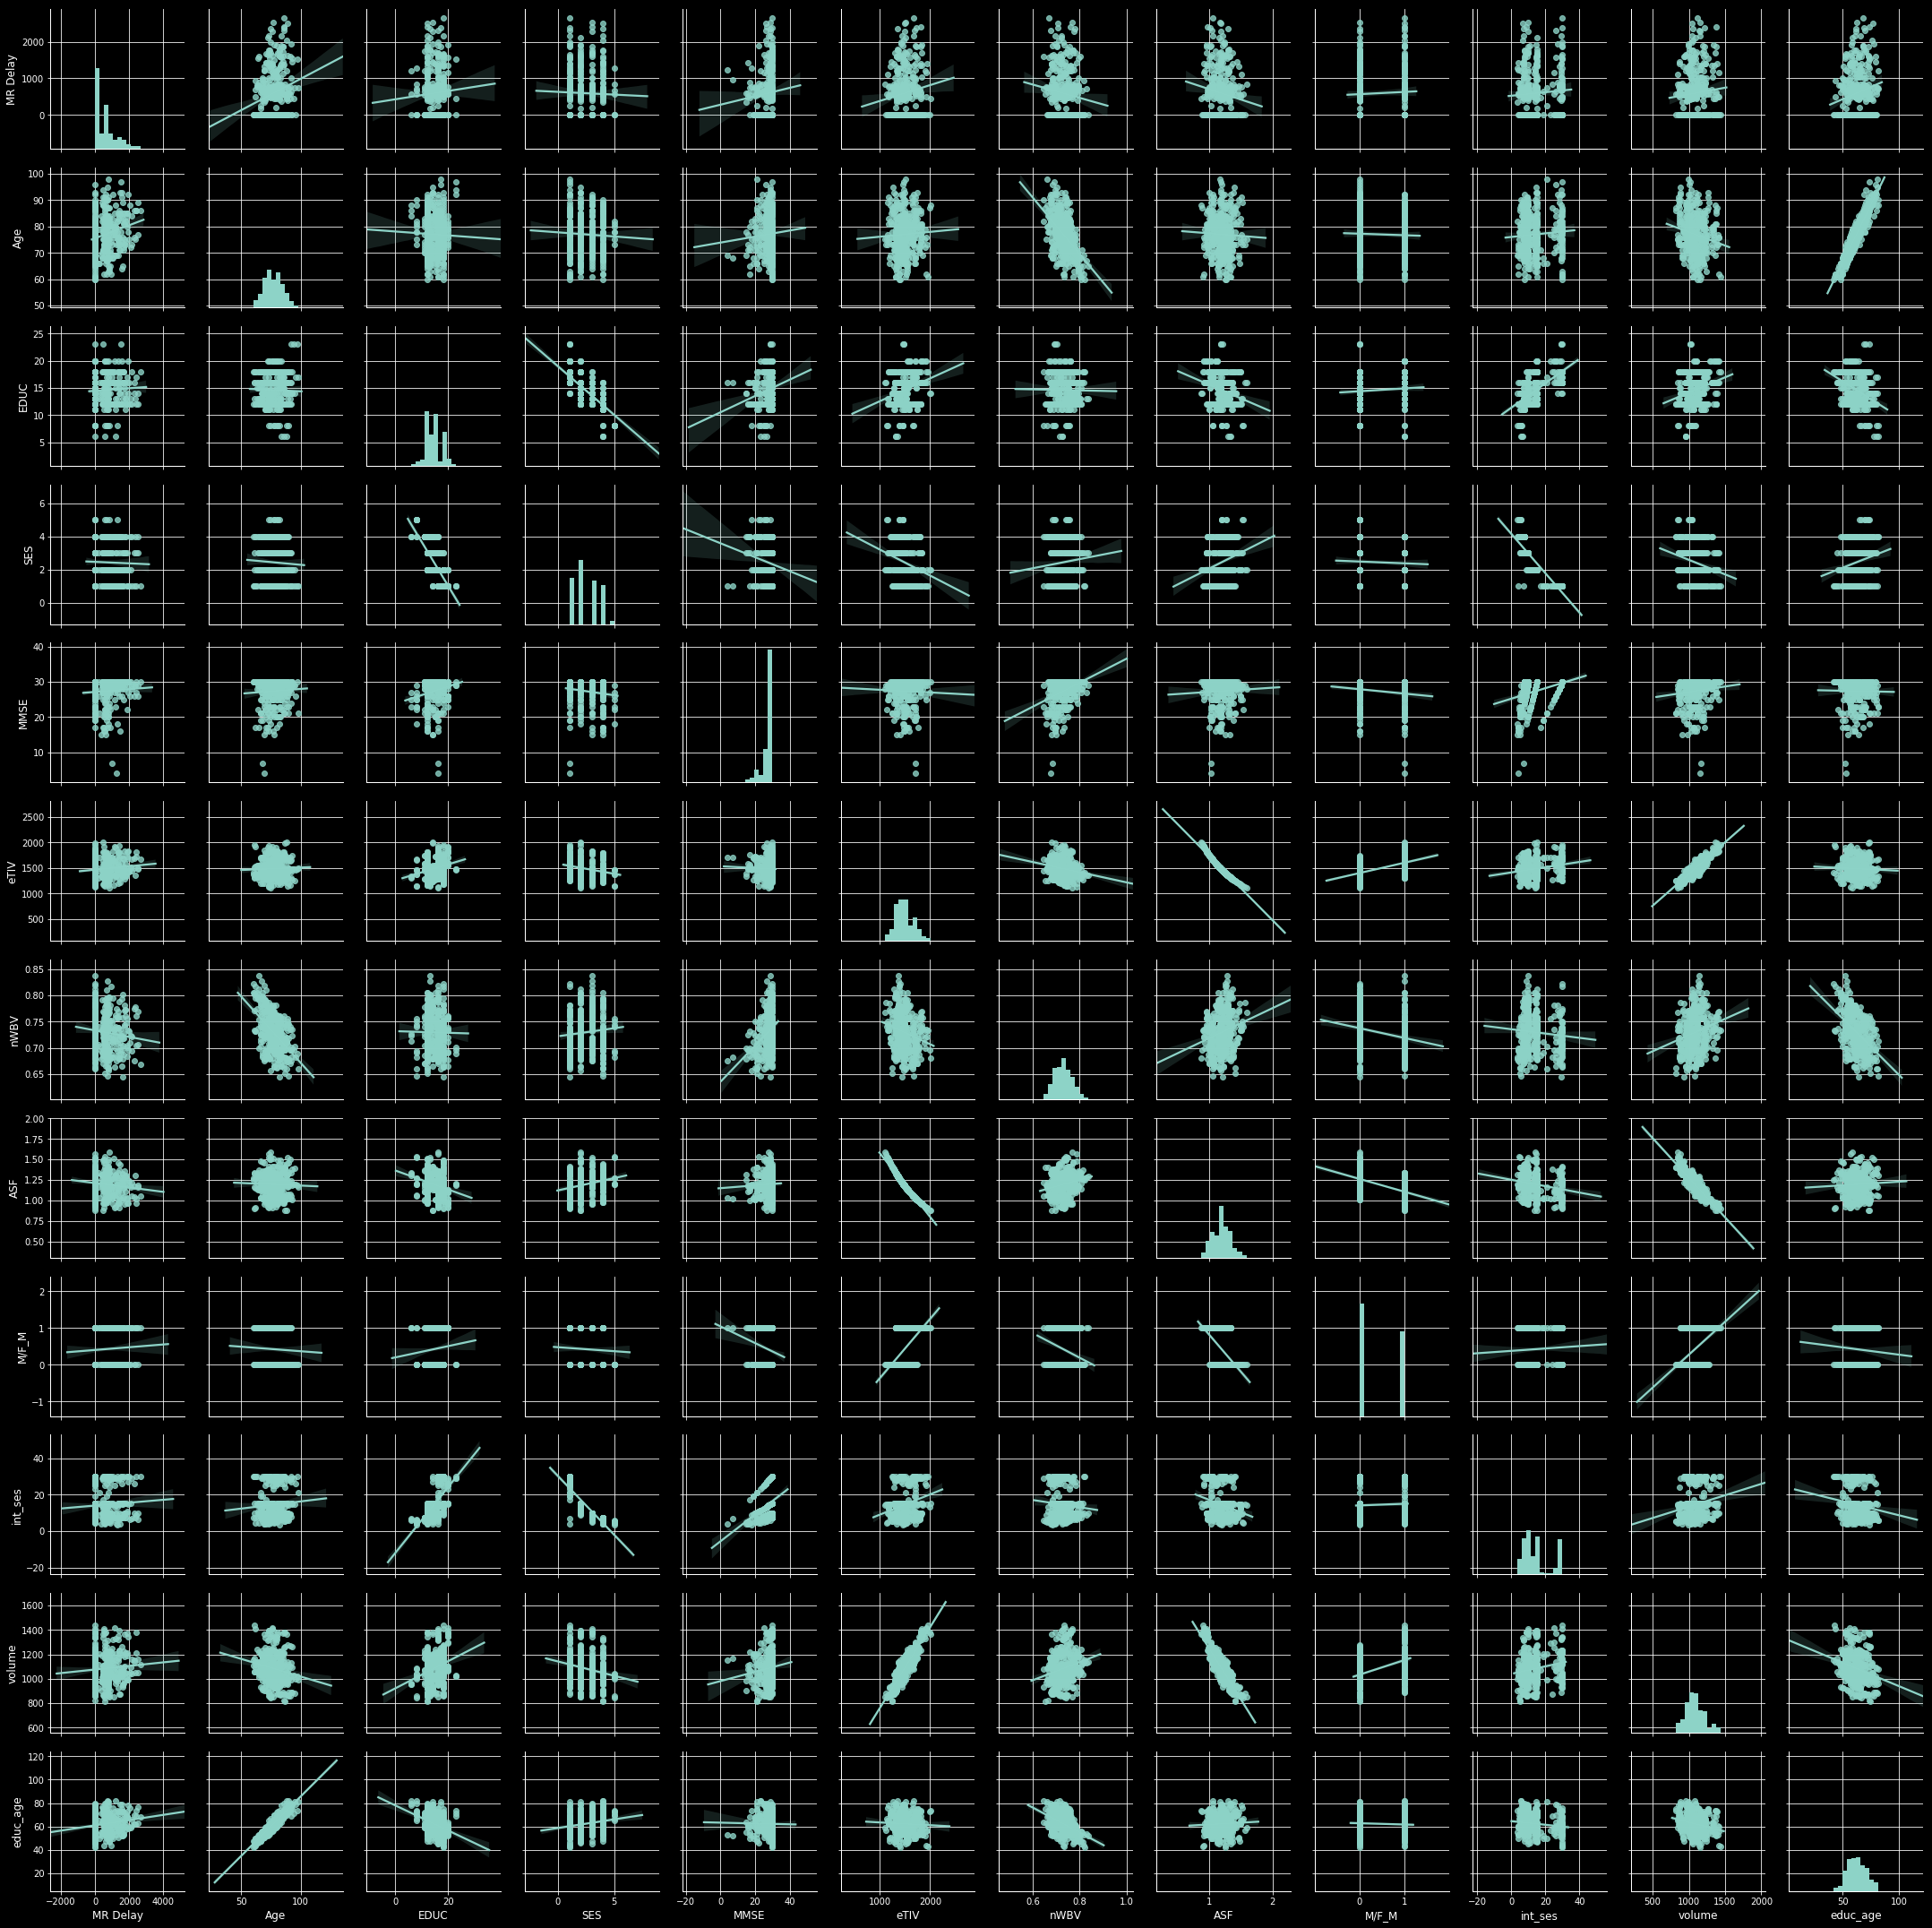

In [78]:
plt.style.use('dark_background')
sns.pairplot(X, kind='reg',diag_kind='hist')

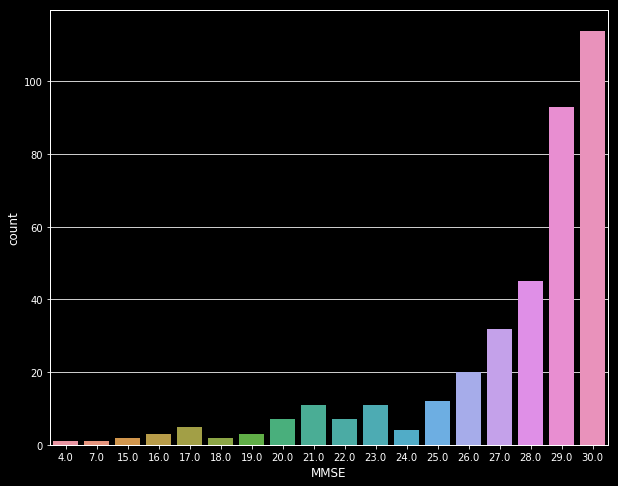

In [79]:
X_new = X.copy()
X_new['class'] = y
plt.figure(figsize=(10,8))
sns.countplot(x='MMSE',data=X_new)

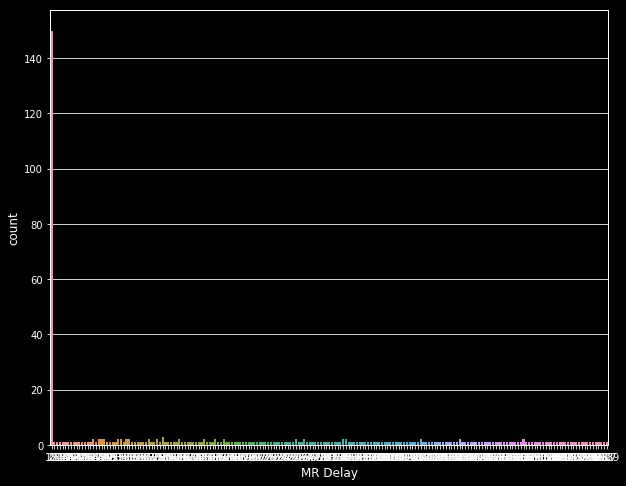

In [80]:
plt.figure(figsize=(10,8))
sns.countplot(x='MR Delay',data=X_new)

In [81]:
X['MR Delay'].value_counts()

0       150
580       3
756       2
842       2
647       2
665       2
610       2
1631      2
673       2
576       2
539       2
567       2
764       2
457       2
1204      2
846       2
504       2
472       2
486       2
518       2
538       2
1345      2
489       2
493       1
1752      1
729       1
672       1
1695      1
670       1
730       1
       ... 
2288      1
751       1
1770      1
1019      1
742       1
600       1
1806      1
1713      1
1340      1
790       1
851       1
2386      1
1927      1
1218      1
1351      1
1861      1
2369      1
1343      1
830       1
828       1
778       1
1707      1
1331      1
817       1
807       1
802       1
432       1
793       1
791       1
743       1
Name: MR Delay, Length: 201, dtype: int64

## Shap Explanations

In [82]:
X.head()

,MR Delay,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,M/F_M,int_ses,volume,educ_age
Subject ID,,,,,,,,,,,,
OAS2_0001,0,87,14,2.0,27.0,1987,0.696,0.883,1,13.5,1382.952,73
OAS2_0001,457,88,14,2.0,30.0,2004,0.681,0.876,1,15.0,1364.724,74
OAS2_0002,0,75,12,2.0,23.0,1678,0.736,1.046,1,11.5,1235.008,63
OAS2_0002,560,76,12,2.0,28.0,1738,0.713,1.010,1,14.0,1239.194,64
OAS2_0002,1895,80,12,2.0,22.0,1698,0.701,1.034,1,11.0,1190.298,68


In [83]:
from shapely import geometry
plt.style.use('ggplot')
new_X = X.drop(['MR Delay','SES','ASF','nWBV'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)
xgbee.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgbee, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

AttributeError: module 'shapely' has no attribute 'TreeExplainer'

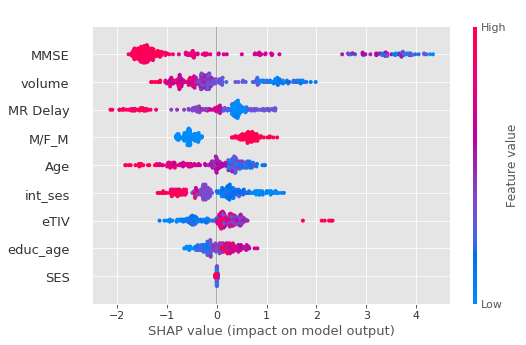

In [144]:
shap.summary_plot(shap_values, X_train)

In [149]:
rf1 = RandomForestClassifier().fit(X_train, y_train)
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rf1.predict_proba(data_for_prediction_array)

explainer = shap.TreeExplainer(rf1)
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Could not find feature named: EDUC


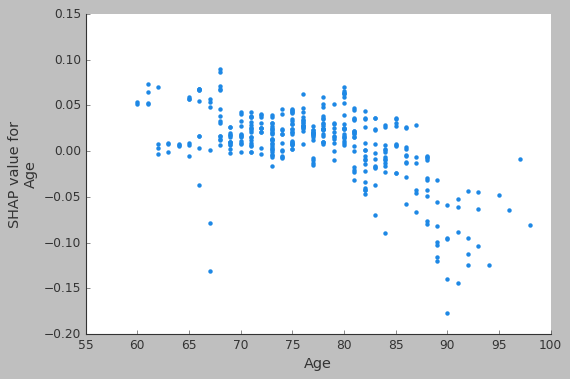

In [150]:
shap_values = explainer.shap_values(X)

shap.dependence_plot('Age', shap_values[1], X, interaction_index="EDUC")

# Models

## MLP

In [84]:
from sklearn.preprocessing import RobustScaler
new_X = X.drop(['ASF','nWBV'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)

In [85]:
mlp = MLPClassifier(hidden_layer_sizes=(200,200,200))
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
steps = [('scaler', StandardScaler()), ('mlp', mlp)]
alpha_space = [0.00001,0.0001,0.001,0.01]
params = [{'mlp__alpha' : alpha_space, 'mlp__solver':['lbfgs', 'sgd', 'adam'], 
               'mlp__learning_rate':['constant','invscaling','adaptive'],
              'mlp__max_iter':[10000,15000,20000],'mlp__activation':['identity', 'logistic', 'tanh', 'relu']}]
pipe = Pipeline(steps)
grid2 = GridSearchCV(pipe, param_grid=params, cv=5)

grid2.fit(X_train, y_train)
print("score = %3.2f" %(grid2.score(X_test,y_test)))
print(grid2.best_params_)

from sklearn.metrics import confusion_matrix
pred2 = grid2.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, pred2))

score = 0.80
{'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 10000, 'mlp__solver': 'sgd'}
[[54 12]
 [10 36]]


In [86]:
print("Tuned MLP Parameters: {}".format(grid2.best_params_))
print("Best score is {}".format(grid2.best_score_))
print("Best estimator is {}".format(grid2.best_estimator_))

Tuned MLP Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 10000, 'mlp__solver': 'sgd'}
Best score is 0.8888888888888888
Best estimator is Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200), learning_rate='adaptive',
       learn...e=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])


## SVM

In [87]:
from sklearn.svm import SVC

svm = SVC()
param_grid_svm = [{'svc__gamma' : [0.000001,0.00001, 0.0001 ,0.001, 0.01], 'svc__C':[0.01, 0.1, 1],
                   'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'svc__degree':[1,2,3,4,5]}]
steps = [('scaler', RobustScaler()), ('svc', svm)]
pipe = Pipeline(steps)

In [88]:
svm_cv=GridSearchCV(pipe, param_grid_svm, cv = 3)
svm_cv.fit(X_train, y_train)    
svm_cv.best_params_

{'svc__C': 1, 'svc__degree': 1, 'svc__gamma': 1e-06, 'svc__kernel': 'linear'}

In [89]:
svm_pred=svm_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[56 10]
 [ 9 37]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        66
           1       0.79      0.80      0.80        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.82      0.83      0.83       112
weighted avg       0.83      0.83      0.83       112



## Logistic Regression


In [90]:
log = LogisticRegression()
param_grid_log = [{'log__C' : [1,10,100], 'log__solver':['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}]
steps = [('scaler', RobustScaler()), ('log', log)]
pipe = Pipeline(steps)

In [91]:
log_cv=GridSearchCV(pipe, param_grid_log, cv = 3)
log_cv.fit(X_train, y_train)    
log_cv.best_params_

{'log__C': 1, 'log__solver': 'liblinear'}

In [92]:
log_pred = log_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

[[54 12]
 [10 36]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.75      0.78      0.77        46

   micro avg       0.80      0.80      0.80       112
   macro avg       0.80      0.80      0.80       112
weighted avg       0.81      0.80      0.80       112



## KNN


In [93]:
knn = KNeighborsClassifier()
param_grid_knn = [{'knn__n_neighbors' : [1,3,5,7,9], 'knn__algorithm':['auto', 'ball_tree', 'kd_tree','brute']}]
steps = [('scaler', RobustScaler()), ('knn', knn)]
pipe = Pipeline(steps)

In [94]:
knn_cv=GridSearchCV(pipe, param_grid_knn, cv = 3)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9], 'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [95]:
knn_pred = knn_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

[[58  8]
 [12 34]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        66
           1       0.81      0.74      0.77        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



## XGBoost

In [96]:
import xgboost as xgb
xgbee = XGBClassifier()
xgbee.fit(X_train,y_train)
xgbee_pred = xgbee.predict(X_test)
print(confusion_matrix(y_test, xgbee_pred))
print(classification_report(y_test, xgbee_pred))
print(xgbee.feature_importances_)

[[58  8]
 [11 35]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        66
           1       0.81      0.76      0.79        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.83      0.82      0.82       112
weighted avg       0.83      0.83      0.83       112

[0.07282348 0.06661728 0.08754708 0.         0.42938998 0.0654242
 0.09121048 0.06308172 0.07206974 0.05183607]


In [97]:
#print(grid2.best_estimator_.score(X_test,y_test))
print(svm_cv.best_estimator_.score(X_test,y_test))
print(log_cv.best_estimator_.score(X_test,y_test))
print(knn_cv.best_estimator_.score(X_test,y_test))
print(xgbee.score(X_test,y_test))

0.8303571428571429
0.8035714285714286
0.8214285714285714
0.8303571428571429


## Keras

In [98]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

classifier = Sequential()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(261, 10) (112, 10)
(261, 1) (112, 1)


In [102]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate=0.1))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dropout(rate=0.1))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 500)

ValueError: Error when checking input: expected dense_1_input to have shape (9,) but got array with shape (10,)

In [140]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred >= 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
#print(classifier.score(X_test, y_test))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78        66
           1       0.74      0.43      0.55        46

   micro avg       0.71      0.71      0.71       112
   macro avg       0.72      0.66      0.66       112
weighted avg       0.71      0.71      0.69       112

[[59  7]
 [26 20]]


In [73]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [1]:
# uncomment out the grid_search stuff if downloading off github (was printing every epoch on there)

#classifier = KerasClassifier(build_fn = build_classifier)
#parameters = {'batch_size': [25, 32],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}
#grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
#grid_search = grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)
#print(grid_search.best_score_)

IndentationError: unexpected indent (<ipython-input-1-370b3bf494f2>, line 5)

In [2]:
#predictions = grid_search.best_estimator_.predict(X_test)
#confusion_matrix(y_test, predictions)

## Voting Classifier

## voting classifier

In [160]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection

In [171]:
#vote_est = [('etc',ensemble.ExtraTreesClassifier()),
           # ('gb',GradientBoostingClassifier()),
            #('abc',AdaBoostClassifier()),
   # ('rfc', ensemble.RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=200)),
    #('svc', svm.SVC(probability=True)),
    #('xgb', XGBClassifier()),
            #('lbgm',LGBMClassifier())
    #       ]



clfs_w_names =[("XGB",xgbee),
       ("KNN",knn_cv),
       ("LOgREG",log_cv),
       ("EXTRAtrees",ExtraTreesClassifier()),
       ("GRADIENT",GradientBoostingClassifier()),
       ("ADA",AdaBoostClassifier())]



Confusion Matrix:
[[59  7]
 [ 9 37]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        66
           1       0.84      0.80      0.82        46

   micro avg       0.86      0.86      0.86       112
   macro avg       0.85      0.85      0.85       112
weighted avg       0.86      0.86      0.86       112



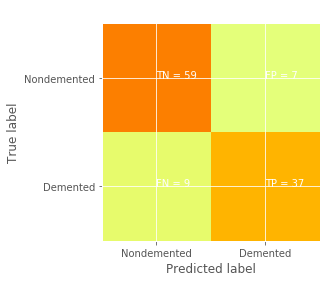

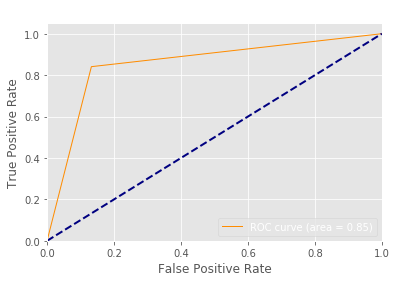


Acuuracy Of the Model:  0.8571428571428571 




In [172]:
#vote_est = [('etc',ensemble.ExtraTreesClassifier()),
           # ('gb',GradientBoostingClassifier()),
            #('abc',AdaBoostClassifier()),
   # ('rfc', ensemble.RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=200)),
    #('svc', svm.SVC(probability=True)),
    #('xgb', XGBClassifier()),
            #('lbgm',LGBMClassifier())
    #       ]


vote_hard = ensemble.VotingClassifier(estimators = clfs_w_names , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, np.ravel(y_train))
vote_hard.fit(X_train, np.ravel(y_train))
report_performance(vote_hard) 
roc_curves(vote_hard)
accuracy(vote_hard)
#pred = vote_hard.predict(X_test)
#accu = metrics.accuracy_score(y_test,pred)
#print("\nAcuuracy Of the Model: ",accu,"\n\n")



Confusion Matrix:
[[60  6]
 [ 8 38]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        66
           1       0.86      0.83      0.84        46

   micro avg       0.88      0.88      0.88       112
   macro avg       0.87      0.87      0.87       112
weighted avg       0.87      0.88      0.87       112



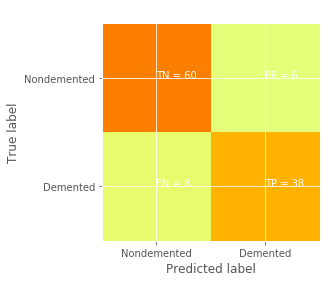

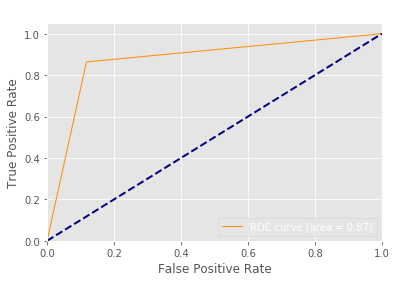


Acuuracy Of the Model:  0.875 




In [173]:


vote_soft = ensemble.VotingClassifier(estimators = clfs_w_names , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, np.ravel(y_train))
vote_soft.fit(X_train, np.ravel(y_train))
report_performance(vote_soft) 
roc_curves(vote_soft)
accuracy(vote_soft)
#pred = vote_soft.predict(X_test)
#accu = metrics.accuracy_score(y_test,pred)
#print("\nAcuuracy Of the Model: ",accu,"\n\n")

# Model Comparison


## stuff

In [138]:
from sklearn import metrics
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Nondemented','Demented']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [139]:
from sklearn.metrics import roc_curve, auc
def report_performance(model):

    model_test = model.predict(X_test)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    plot_confusion_metrix(y_test, model_test)

total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

roll thru each and print shit

In [140]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

clfs =[xgbee,knn_cv,log_cv,svm_cv,ExtraTreesClassifier(),GradientBoostingClassifier(),AdaBoostClassifier()]

In [141]:
from sklearn import metrics
total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu

In [142]:
#np.ravel(y_train)

## loop thru each model n plot

XGBClassifier : 


Confusion Matrix:
[[58  8]
 [11 35]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        66
           1       0.81      0.76      0.79        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.83      0.82      0.82       112
weighted avg       0.83      0.83      0.83       112



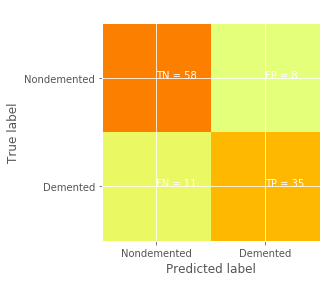

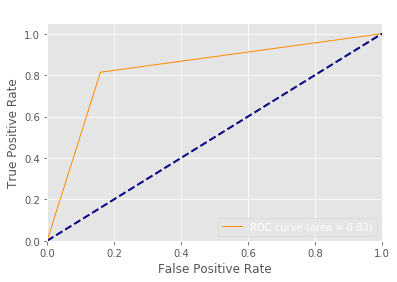


Acuuracy Of the Model:  0.8303571428571429 


GridSearchCV : 


Confusion Matrix:
[[58  8]
 [12 34]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        66
           1       0.81      0.74      0.77        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



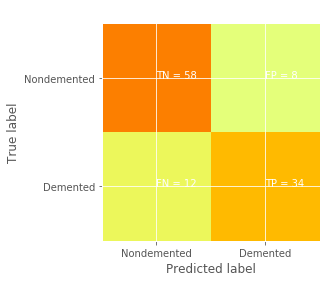

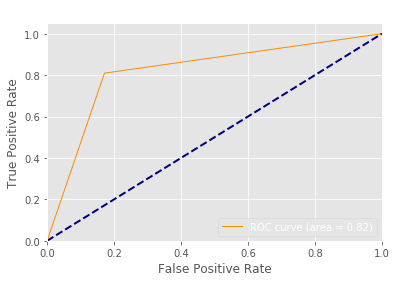


Acuuracy Of the Model:  0.8214285714285714 


GridSearchCV : 


Confusion Matrix:
[[54 12]
 [10 36]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.75      0.78      0.77        46

   micro avg       0.80      0.80      0.80       112
   macro avg       0.80      0.80      0.80       112
weighted avg       0.81      0.80      0.80       112



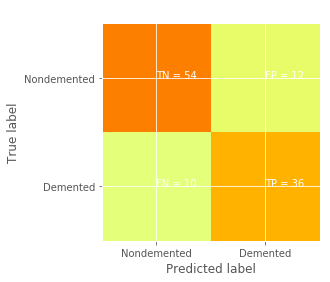

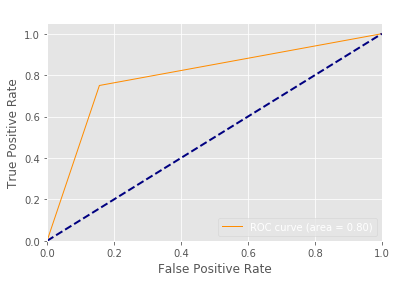


Acuuracy Of the Model:  0.8035714285714286 


GridSearchCV : 


Confusion Matrix:
[[56 10]
 [ 9 37]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        66
           1       0.79      0.80      0.80        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.82      0.83      0.83       112
weighted avg       0.83      0.83      0.83       112



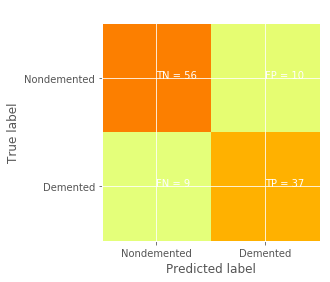

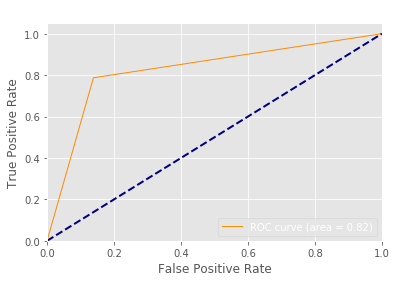


Acuuracy Of the Model:  0.8303571428571429 


ExtraTreesClassifier : 


Confusion Matrix:
[[62  4]
 [ 7 39]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        66
           1       0.91      0.85      0.88        46

   micro avg       0.90      0.90      0.90       112
   macro avg       0.90      0.89      0.90       112
weighted avg       0.90      0.90      0.90       112



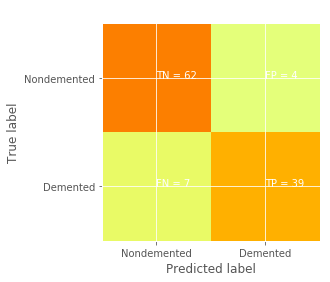

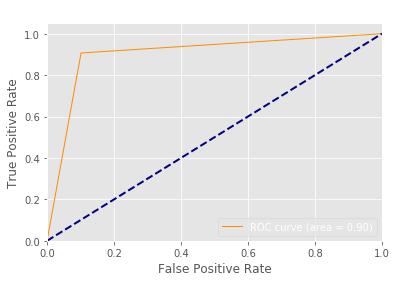


Acuuracy Of the Model:  0.9017857142857143 


GradientBoostingClassifier : 


Confusion Matrix:
[[58  8]
 [ 8 38]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        66
           1       0.83      0.83      0.83        46

   micro avg       0.86      0.86      0.86       112
   macro avg       0.85      0.85      0.85       112
weighted avg       0.86      0.86      0.86       112



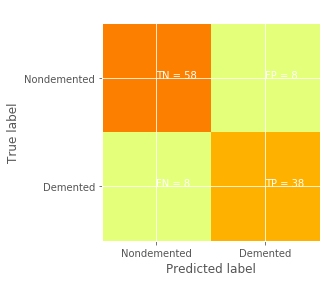

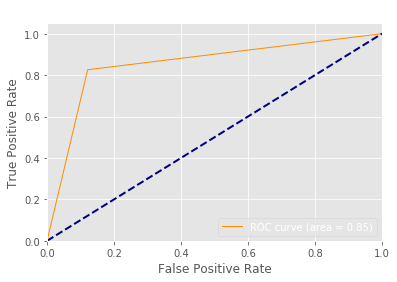


Acuuracy Of the Model:  0.8571428571428571 


AdaBoostClassifier : 


Confusion Matrix:
[[56 10]
 [ 7 39]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        66
           1       0.80      0.85      0.82        46

   micro avg       0.85      0.85      0.85       112
   macro avg       0.84      0.85      0.84       112
weighted avg       0.85      0.85      0.85       112



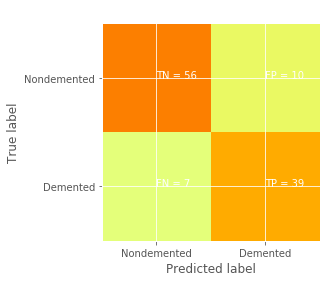

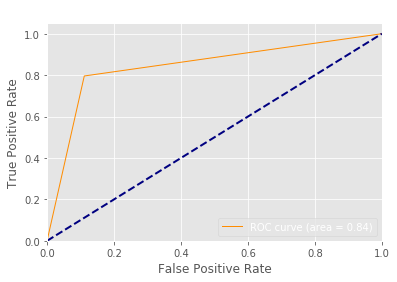


Acuuracy Of the Model:  0.8482142857142857 




In [143]:
for model in clfs:
    print(str(model).split('(')[0],": ")
    model.fit(X_train,np.ravel(y_train))
    X = pd.DataFrame(X_train)
    report_performance(model)
    roc_curves(model)
    accuracy(model)

## all on one plot

plot where all models land together on pone plot?

In [155]:
# Model vs accuracy

data = total_accuracy.values()
#labels = str(clfs)
labels =["xgbee","knn_cv","log_cv","svm_cv","ExtraTreesClassifier()","GradientBoostingClassifier()","AdaBoostClassifier()"]
print(data)
print(labels)

dict_values([0.8303571428571429, 0.8303571428571429, 0.9017857142857143, 0.8571428571428571, 0.8482142857142857])
['xgbee', 'knn_cv', 'log_cv', 'svm_cv', 'ExtraTreesClassifier()', 'GradientBoostingClassifier()', 'AdaBoostClassifier()']


Text(0, 0.5, 'Accuracy')

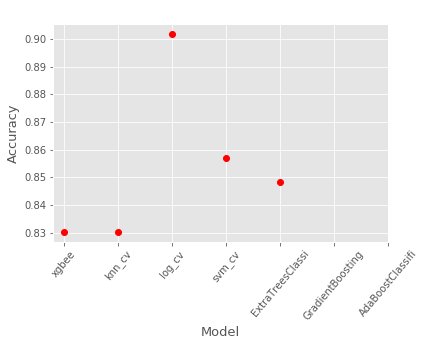

In [159]:
plt.plot([i for i, e in enumerate(data)], data, 'ro'); plt.xticks([i for i, e in enumerate(labels)], [l[0:16] for l in labels])
plt.title("Model Vs Accuracy",fontsize = 14)
plt.xlabel('Model',fontsize = 13)
plt.xticks(rotation = 50)
plt.ylabel('Accuracy',fontsize = 13)

In [194]:
# ponly have 5 data points/ models showing, 
#easier just type out dictionary

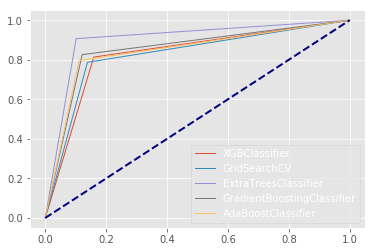

In [157]:
for i in total_fpr.keys():
    plt.plot(total_fpr[i],total_tpr[i],lw=1, label=i)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()

# some EDA graphs/plots

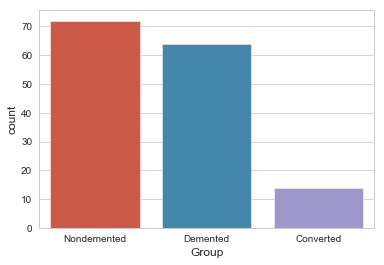

In [176]:
eda = data2
sns.set_style("whitegrid")
ex_df = eda.loc[eda['Visit'] == 1] # #same person visits two or more time so only take the single visit data
sns.countplot(x='Group', data=ex_df)

In [177]:
#the fuck is converted?
eda['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

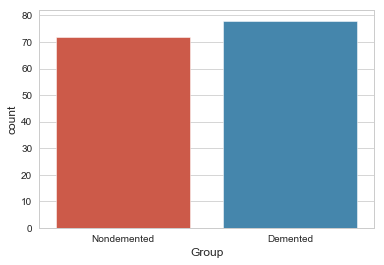

In [179]:
# subjects were characterized as nondemented at the time of their 
#initial visit and were subsequently characterized as demented 
#at a later visit
#We have three groups so convert Converted Group Into Demented

ex_df['Group'] = ex_df['Group'].replace(['Converted'], ['Demented'])
eda['Group'] = eda['Group'].replace(['Converted'], ['Demented'])
sns.countplot(x='Group', data=ex_df)

              F   M
Demented     38  40
Nondemented  50  22


Text(0.5, 1.0, 'Gender and Demented rate')

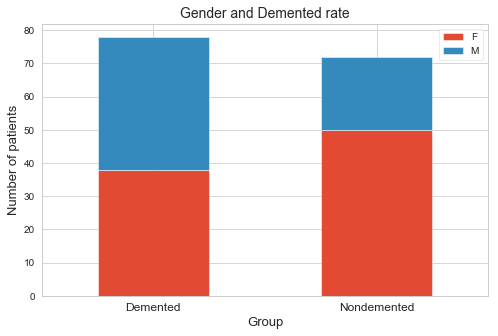

In [180]:
def bar_chart(feature):
    Demented = ex_df[ex_df['Group']=='Demented'][feature].value_counts()
    Nondemented = ex_df[ex_df['Group']=='Nondemented'][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))
    print(df_bar)
                
                
# Gender  and  Group ( Female=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group',fontsize=13)
plt.xticks(rotation=0,fontsize=12)
plt.ylabel('Number of patients',fontsize=13)
plt.legend()
plt.title('Gender and Demented rate',fontsize=14)

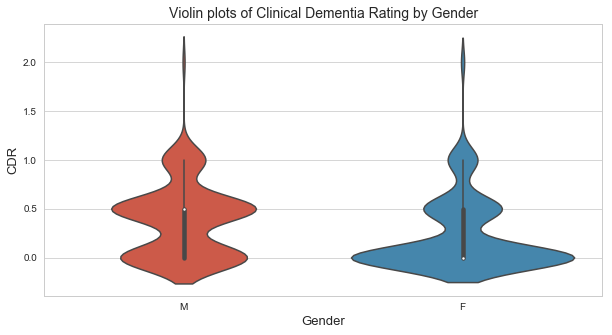

In [185]:
plt.figure(figsize=(10,5))
sns.violinplot(x='M/F', y='CDR', data=eda)
plt.title('Violin plots of Clinical Dementia Rating by Gender',fontsize=14)
plt.xlabel('Gender',fontsize=13)
plt.ylabel('CDR',fontsize=13)
plt.show()

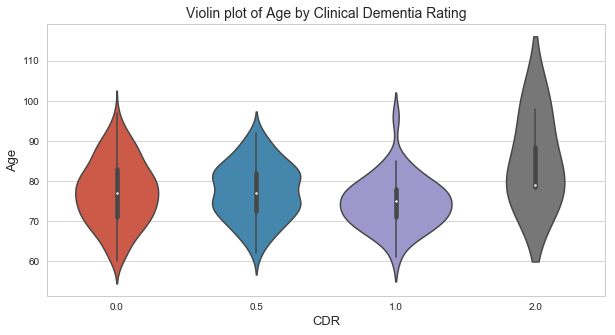

In [186]:
plt.figure(figsize=(10,5))
sns.violinplot(x='CDR', y='Age', data=eda)
plt.title('Violin plot of Age by Clinical Dementia Rating',fontsize=14)
plt.xlabel('CDR',fontsize=13)
plt.ylabel('Age',fontsize=13)
plt.show()

# couple more/extra models

## Random forest

In [ ]:
feature_col_names = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]



Confusion Matrix:
[[57  9]
 [11 35]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        66
           1       0.80      0.76      0.78        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



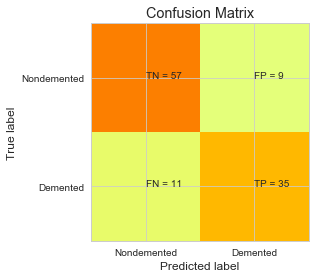

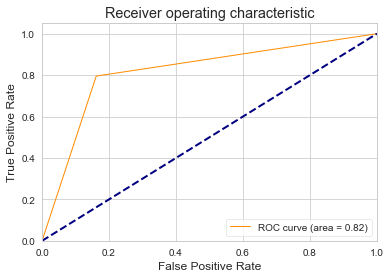


Acuuracy Of the Model:  0.8214285714285714 




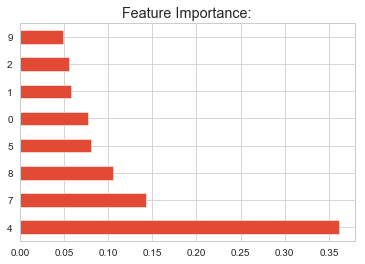

In [191]:
rfc=RandomForestClassifier(criterion='gini',max_depth=8,max_features='auto',n_estimators=200)

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = 'roc_auc')
rfc.fit(X_train, y_train)
#print("Best parameters set found on development set:")
#print(rfc.best_params_)
report_performance(rfc) 
roc_curves(rfc)
accuracy(rfc)

feat_importances = pd.Series(rfc.feature_importances_)
feat_importances.nlargest(8).plot(kind='barh')
plt.title("Feature Importance:")
plt.show()

In [ ]:
# feature_col_names = [ "", "",""]
# add , index=feature_col_names

## D tree



Confusion Matrix:
[[52 14]
 [12 34]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        66
           1       0.71      0.74      0.72        46

   micro avg       0.77      0.77      0.77       112
   macro avg       0.76      0.76      0.76       112
weighted avg       0.77      0.77      0.77       112



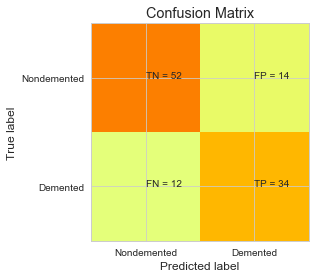

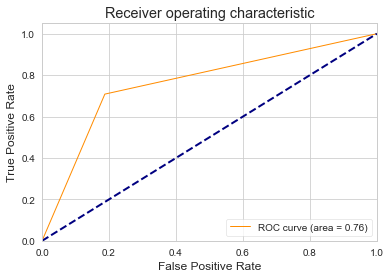


Acuuracy Of the Model:  0.7678571428571429 




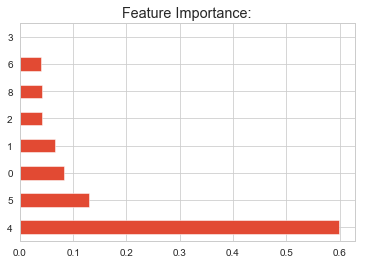

In [192]:
clf_dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=42)
clf_dtc.fit(X_train, y_train)
report_performance(clf_dtc) 
roc_curves(clf_dtc)
accuracy(clf_dtc)
#importances = clf.feature_importances_


feat_importances = pd.Series(clf_dtc.feature_importances_)
feat_importances.nlargest(8).plot(kind='barh')
plt.title("Feature Importance:")
plt.show()

In [ ]:
# same thing again
# make a feature_col_names = [ "", "",""]
# add , index=feature_col_names to pd.Series

# more stuff